# Set Parameter
- Attention = [None, Luong]
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100
- N = 100
- Data Length = 100K
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from trainer.supervised_trainer_unmatching import SupervisedTrainer_unmatching
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentance_accuracy = []
f1_score = []

In [4]:
train_path = "data/unmatching_dedup/K100/data_train.txt"
dev_path = "data/unmatching_dedup/K100/data_test.txt"

src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()
    
optimizer = "Adam"
hidden_size = 50
bidirectional = True

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Prepare dataset

In [ ]:
print("None Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer_unmatching(loss=loss, batch_size=32,
                                checkpoint_every=50,
                                print_every=100,
                                hidden_size=hidden_size,
                                path="unMatching_dedup_K100_parameter/None_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                                            num_epochs=100, dev_data=dev,
                                                                                            optimizer=optimizer,
                                                                                            teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)
f1_score.append(f1_score_list)

torch.save(seq2seq.state_dict(), 'log/pth/unMatching_dedup_K100_parameter_no_att_model_save.pth')

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-03-06 17:00:19,141 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


None Att


2019-03-06 17:03:46,643 INFO   Finished epoch 1: Train loss: 1.5706, Dev loss: 1.4649, Accuracy(character): 0.9012, Accuracy(sentance): 0.0346, F1 Score: 0.2409
2019-03-06 17:07:15,598 INFO   Finished epoch 2: Train loss: 1.4655, Dev loss: 1.4645, Accuracy(character): 0.9012, Accuracy(sentance): 0.0346, F1 Score: 0.2409
2019-03-06 17:10:46,815 INFO   Finished epoch 3: Train loss: 1.4620, Dev loss: 1.4591, Accuracy(character): 0.9012, Accuracy(sentance): 0.0346, F1 Score: 0.2409
2019-03-06 17:14:14,021 INFO   Finished epoch 4: Train loss: 1.4466, Dev loss: 1.4449, Accuracy(character): 0.9015, Accuracy(sentance): 0.0365, F1 Score: 0.2453
2019-03-06 17:18:24,154 INFO   Finished epoch 5: Train loss: 1.4255, Dev loss: 1.4340, Accuracy(character): 0.9027, Accuracy(sentance): 0.0444, F1 Score: 0.2671
2019-03-06 17:22:23,474 INFO   Finished epoch 6: Train loss: 1.3970, Dev loss: 1.4138, Accuracy(character): 0.9051, Accuracy(sentance): 0.0671, F1 Score: 0.3035
2019-03-06 17:26:14,510 INFO   Fin

2019-03-07 09:35:16,178 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Luong Att


/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-03-07 09:39:29,096 INFO   Finished epoch 1: Train loss: 1.5782, Dev loss: 1.4661, Accuracy(character): 0.9012, Accuracy(sentance): 0.0346, F1 Score: 0.2409
2019-03-07 09:43:41,061 INFO   Finished epoch 2: Train loss: 1.4678, Dev loss: 1.4622, Accuracy(character): 0.9012, Accuracy(sentance): 0.0346, F1 Score: 0.2410
2019-03-07 09:47:57,127 INFO   Finished epoch 3: Train loss: 1.4511, Dev loss: 1.4405, Accuracy(character): 0.9017, Accuracy(sentance): 0.0363, F1 Score: 0.2495
2019-03-07 09:52:08,963 INFO   Finished epoch 4: Train loss: 1.3860, Dev loss: 1.3560, Accuracy(character): 0.9040, Accuracy(sentance): 0.0713, F1 Score: 0.3162
2019-03-07 09:56:18,785 INFO   Finished epoch 5: Train loss: 1.2666, Dev loss: 1.2811, Accuracy(character): 0.9130, Accurac

2019-03-07 13:10:19,227 INFO   Finished epoch 51: Train loss: 1.0297, Dev loss: 1.0476, Accuracy(character): 0.9862, Accuracy(sentance): 0.5882, F1 Score: 0.9388
2019-03-07 13:14:30,986 INFO   Finished epoch 52: Train loss: 1.0274, Dev loss: 1.0383, Accuracy(character): 0.9883, Accuracy(sentance): 0.6059, F1 Score: 0.9485
2019-03-07 13:18:43,007 INFO   Finished epoch 53: Train loss: 1.0268, Dev loss: 1.0550, Accuracy(character): 0.9846, Accuracy(sentance): 0.5826, F1 Score: 0.9329
2019-03-07 13:22:54,402 INFO   Finished epoch 54: Train loss: 1.0266, Dev loss: 1.0360, Accuracy(character): 0.9886, Accuracy(sentance): 0.6259, F1 Score: 0.9488
2019-03-07 13:27:09,034 INFO   Finished epoch 55: Train loss: 1.0274, Dev loss: 1.0378, Accuracy(character): 0.9878, Accuracy(sentance): 0.6023, F1 Score: 0.9456
2019-03-07 13:31:22,185 INFO   Finished epoch 56: Train loss: 1.0260, Dev loss: 1.0363, Accuracy(character): 0.9885, Accuracy(sentance): 0.6238, F1 Score: 0.9495
2019-03-07 13:35:34,428 INFO

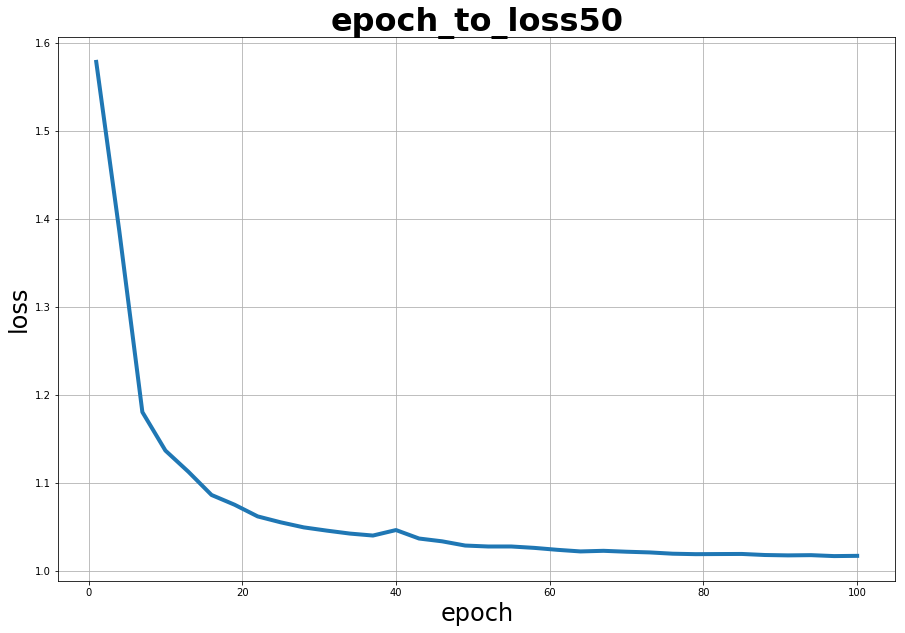

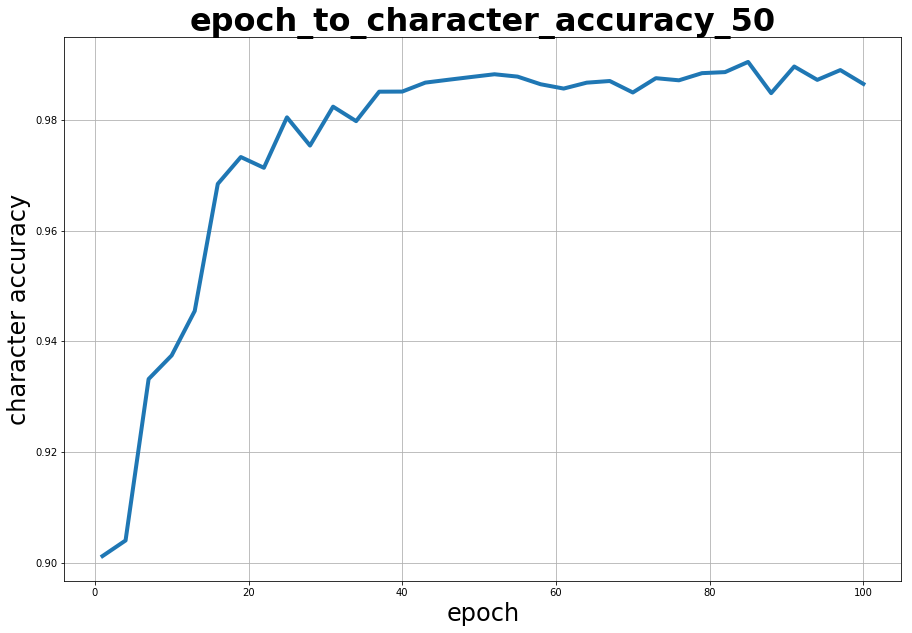

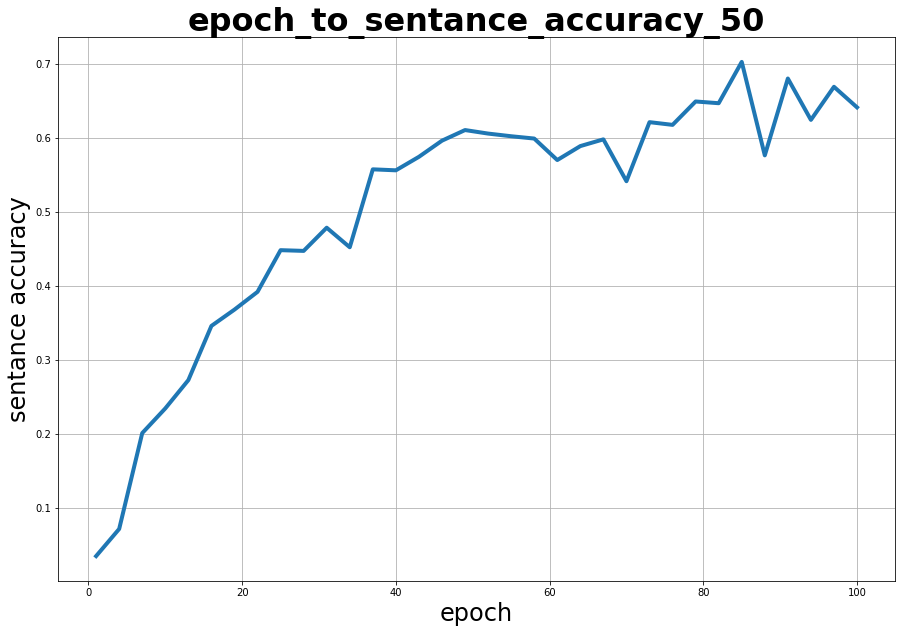

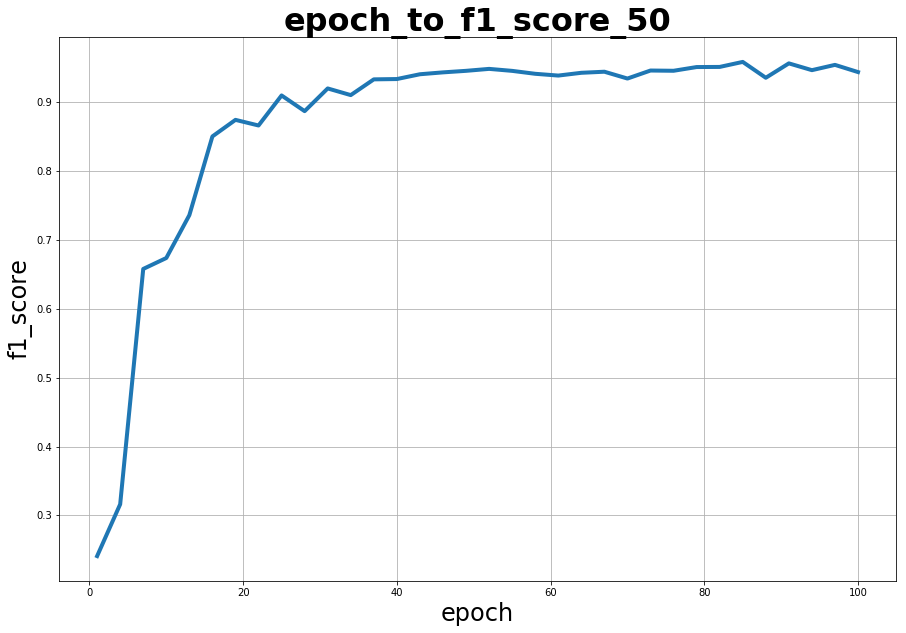

In [6]:
print("Luong Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer_unmatching(loss=loss, batch_size=32,
                                checkpoint_every=50,
                                print_every=100,
                                hidden_size=hidden_size,
                                path="unMatching_dedup_K100_parameter/Luong_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                                            num_epochs=100, dev_data=dev,
                                                                                            optimizer=optimizer,
                                                                                            teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)
f1_score.append(f1_score_list)

torch.save(seq2seq.state_dict(), 'log/pth/unMatching_dedup_K100_parameter_Luong_att_model_save.pth')

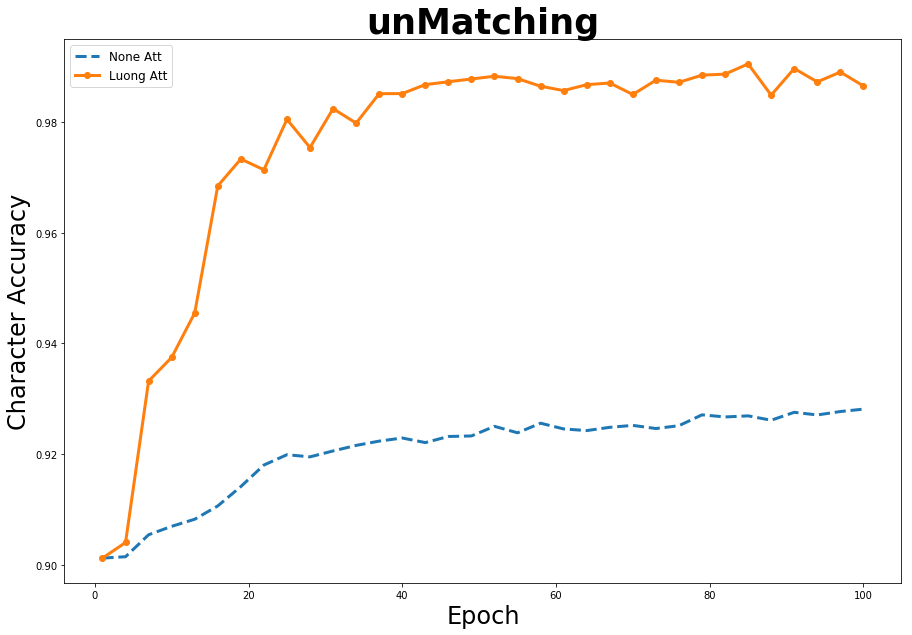

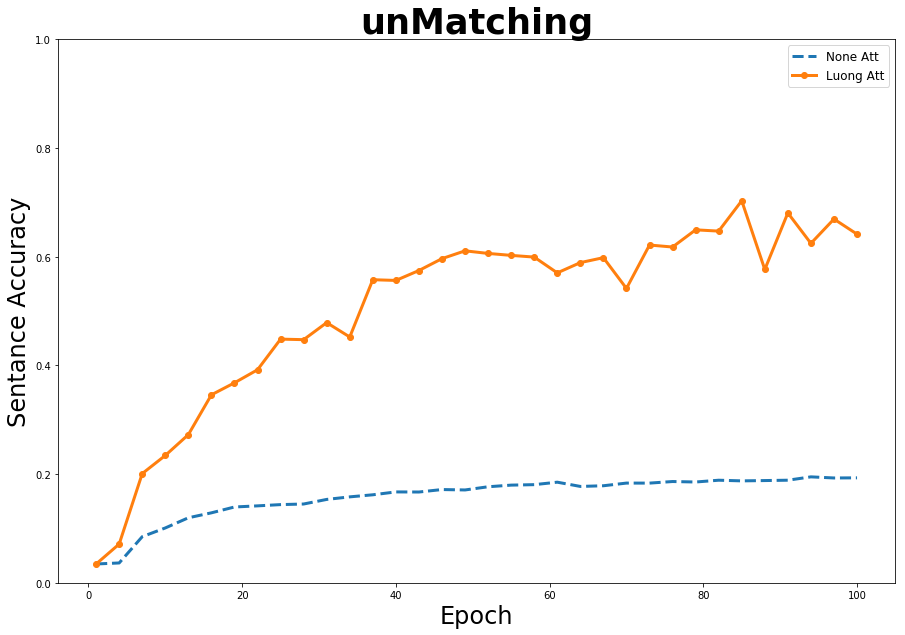

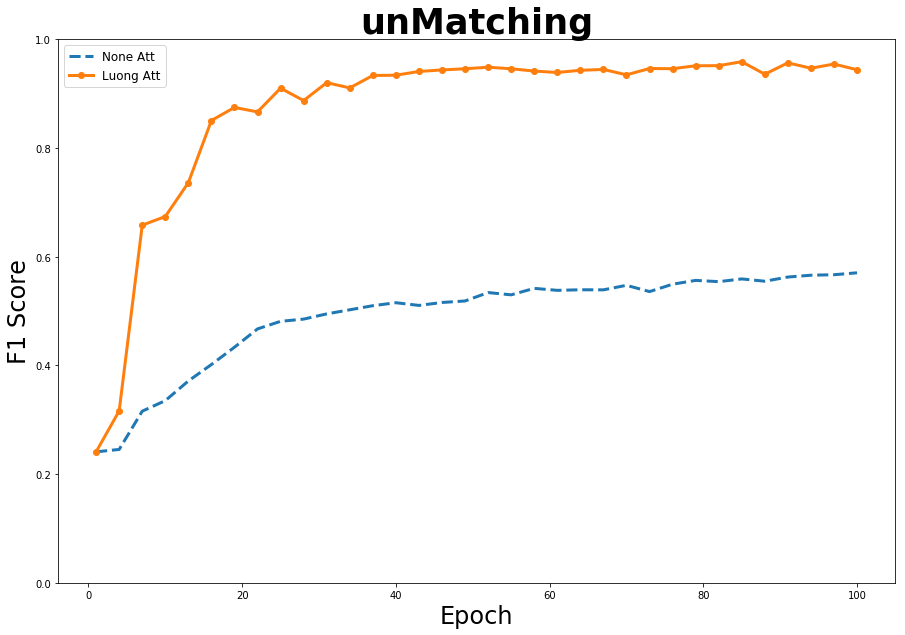

In [13]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], character_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], character_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
#plt.ylim([0, 1])
plt.title('unMatching', fontsize=35, fontweight=560)
plt.savefig('log/plot/unMatching_dedup_K100_parameter/epoch_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], sentance_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], sentance_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('unMatching', fontsize=35, fontweight=560)
plt.savefig('log/plot/unMatching_dedup_K100_parameter/epoch_to_sentance_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], f1_score[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], f1_score[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1])
plt.title('unMatching', fontsize=35, fontweight=560)
plt.savefig('log/plot/unMatching_dedup_K100_parameter/epoch_to_f1_score.png')

In [8]:
print(character_accuracy[0])
print(character_accuracy[1])

[0.9012266382540686, 0.9012253260959063, 0.9012266382540686, 0.901472011830418, 0.9027005199098679, 0.9050532194948651, 0.9054416183109048, 0.9062187439825247, 0.9058975932723027, 0.906962409621006, 0.907466934434409, 0.9082355310779741, 0.9082450442246507, 0.9090972909510621, 0.9092665593539982, 0.9106472777802745, 0.9119758379195995, 0.9140096830711587, 0.9141435232037128, 0.9160048195569301, 0.915038415070399, 0.9180360403921647, 0.9185612316966237, 0.9190099897881291, 0.9198970087058413, 0.9202529316073642, 0.9190703490635947, 0.9195125463642886, 0.9206278808022403, 0.9209677297662751, 0.9205793309502354, 0.9207226842294662, 0.9206888961567872, 0.9215778833117428, 0.9221827882245615, 0.9212806794879828, 0.9223546809438222, 0.9211868601793786, 0.9224567012409408, 0.9229166126768256, 0.9237472087935591, 0.9227607938950529, 0.9220896249950384, 0.9216280733614507, 0.9239610905740134, 0.9231895415745832, 0.9231954462863136, 0.9233712754800613, 0.9232895936344583, 0.9248313794751564, 0.9

In [9]:
print(sentance_accuracy[0])
print(sentance_accuracy[1])

[0.03461482117070925, 0.0345729652805391, 0.03461482117070925, 0.036498336228365735, 0.04443002741560806, 0.06713684783291128, 0.08484188937488228, 0.09294100412280518, 0.0951802942469079, 0.10089362325513258, 0.11158780319360442, 0.11213192976581629, 0.11960320616118704, 0.12456312914634912, 0.11776154699370069, 0.1287068622731934, 0.1310298641776364, 0.13490153401837474, 0.13946382604692045, 0.1376221668794341, 0.13693154469162672, 0.1415356926103426, 0.1414519808300023, 0.1397358893330264, 0.14383776656970051, 0.14390055040495572, 0.14687231860703598, 0.14494694765920935, 0.150367285436243, 0.15260657556034574, 0.1533809095284934, 0.1550970010254693, 0.14982315886403114, 0.15808969717263463, 0.15767113827093318, 0.15752464265533767, 0.16189858317811773, 0.16114517715505514, 0.16413787330222046, 0.167193353284641, 0.16809325492329907, 0.1666492267124291, 0.16700500177887534, 0.1644099365883264, 0.16545633384258, 0.171546365862336, 0.172425339555909, 0.16654458698700375, 0.17079295983

In [10]:
print(f1_score[0])
print(f1_score[1])

[0.24092187925418734, 0.24090414053203718, 0.24092187925418734, 0.24531516183986368, 0.26712426924426386, 0.3035103553678231, 0.3157134645441114, 0.3248605991872224, 0.3292765935549063, 0.3350920697332336, 0.34817662078152756, 0.3491748667844597, 0.3712607198325343, 0.3726147492866064, 0.38150773123733384, 0.40152282029840236, 0.40521520145503326, 0.42799631075345423, 0.43339512797996554, 0.44913405918914495, 0.43202865879223035, 0.46705371713702265, 0.4703754324520566, 0.47451370699447804, 0.481001398160897, 0.4855189774711396, 0.47570995371601854, 0.48508522727272735, 0.4937098220646534, 0.49248884502812995, 0.4946868990887049, 0.49454298693709825, 0.49004596768741976, 0.5022309328218172, 0.5049999373179609, 0.5021848767446792, 0.5097390947236112, 0.5057606250154524, 0.5068619054581914, 0.5152242347576793, 0.5196681885728714, 0.51449083789098, 0.5102767802381842, 0.5056335489804923, 0.5204309717995621, 0.5156796012933935, 0.5225866817026632, 0.5238882628647952, 0.518444000082459, 0.5